<img src="images/JHI_STRAP_Web.png" style="width: 150px; float: right;">

# Supplementary Information: Holmes *et al.* 2017

# 3. Crossvalidation

This notebook describes analysis of 10-fold crossvalidation data of the Bayesian hierarchical model described in notebook `02-full_model_fit.ipynb`. This model estimates the selective effects on growth (control) and leaf passage (treatment) due to individual genes from *E. coli* DH10B (carrier) and Sakai (BAC load). The estimates are made on the basis of data obtained using a multi-*E. coli* microarray.

Much of the code for the visualisation, analysis and data manipulation of the fitting results is found in the associated Python module `tools.py`, which should also be present in this directory.

## Table of Contents

 1. [Crossvalidation summary](#summary)
 2. [Load results](#load)
    1. [Load full fit](#loadfit)
    2. [Merge crossvalidation and fit](#merge)    
 3. [Calculate prediction errors](#errors)
    1. [Error distributions](#errdist)
    2. [Error with respect to measured output intensity](#erroutput)
    3. [Error with respect to estimated treatment effect](#errtrt)
    4. [Error with respect to prediction interval](#errinterval)
    5. [Prediction errors for positive treatment effects](#errpos)
 4. [Prediction errors for positive treatment effect candidates](#candidates)
    1. [Plotting distribution of effects](#plot_effects)
 5. [Identifying candidates](#candidates)
    1. [Calculating Type M and Type S errors](#calc_errors)
    2. [Over- and Under-estimates](#overunder)

<a id="summary"></a>
## Crossvalidation summary

We will load predicted and measured *output* probe intensity data from a 10-fold crossvalidation, performed as described in the file `README.md` (the data provided in this repository was obtaind from a run on the JHI cluster).

<br /><div class="alert-success">
<b>The Stan model used to generate the crossvalidation results is identical in form to that used in the notebook `02-full_model_fit.ipynb`, except that it is fit ten times, each time on a random 90% of the data, and a prediction made for the *output* probe intensity of the remaining 10% of the data, given the measured *input* probe intensities as a predictor. The results of these ten runs are combined in the file `10-fold_CV.tab`.</b>
</div>

We can assess the applicability and success of the Stan model by investigating how well it can predict the measured *output* intensity of a probe, given its measured *input* intensity. We are conducting crossvalidation on the original dataset, and we consider a prediction to be "correct" if the measured *output* intensity lies within the 90% credibility interval of the *predicted output* intensity.

<br /><div class="alert-success">
<b>We assess the performance of the model in two ways.</b>
</div>

1. Failed predictions as those predictions of output intensity that do not include the measured input intensity in their 90% CI. 
2. As Type S/Type M errors for the failed predictions (after [Gelman & Carlin (2014) DOI: 10.1177/1745691614551642](http://www.stat.columbia.edu/~gelman/research/published/PPS551642_REV2.pdf)). Here, we assess the performance of the model by comparing the median predicted output intensity to the measured output intensity, for each probe. If the difference between predicted output intensity and measured input intensity has the opposite sign to that for the difference between measured output intensity and measured input intensity, we consider the prediction to be a **Type S (sign) error**. If, however, the *direction* of the prediction is correct (no Type S error), but the magnitude is incorrect, we consider this prediction to be a **Type M (magnitude) error**. We can tabulate these results in the same way as we might do so for false positive and false negative errors.

## Python imports

In [1]:
%pylab inline

import os

import numpy as np
import pandas as pd
import pickle
import scipy
import seaborn as sns

import tools

import warnings
warnings.filterwarnings('ignore')

sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


<a id="load"></a>
## Load results

We load data from the multiplexed run that was performed on the JHI cluster, as described in `README.md`. 

The column containing the experimentally-measured predictor (*input* intensity) is headed `log_input`, and the column containing the measured *output* probe intensity is headed `log_output`. 

The *predicted output* mean and median values for 1000 iterations of two chains are found in the columns `y_pred_mean` and `y_pred_median`. 5%, 25%, 75% and 95% percentiles for *predicted output* are given in the columns `y_pred_5pc`, `y_pred_25pc`, `y_pred_75pc` and `y_pred_95pc`. These can be combined to provide 50% and 90% credibility intervals for each predicted output intensity.

In [2]:
# Crossvalidation results file
resultsfile = os.path.join("datasets", "10-fold_CV.tab")

# Load predictions from file
results = pd.read_csv(resultsfile, sep='\t', index_col=0)
print(results.shape)
print(results.columns)

(49872, 20)
Index(['probe', 'replicate', 'treatment', 'repXtrt', 'input', 'output',
       'log_input', 'log_output', 'match', 'locus_tag', 'probe_index',
       'locus_tag_index', 'repXtrt_index', 'y_pred_25pc', 'y_pred_5pc',
       'y_pred_75pc', 'y_pred_95pc', 'y_pred_mean', 'y_pred_median',
       'y_pred_sem'],
      dtype='object')


In [3]:
# Inspect crossvalidation results
results.head()

,probe,replicate,treatment,repXtrt,input,output,log_input,log_output,match,locus_tag,probe_index,locus_tag_index,repXtrt_index,y_pred_25pc,y_pred_5pc,y_pred_75pc,y_pred_95pc,y_pred_mean,y_pred_median,y_pred_sem
4842,A_07_P010704,3,1,rep3trt1,1881.971667,1384.856333,7.540075,7.233352,lcl|NC_010473.1_cds_WP_001264707.1_2,ECDH10B_RS00010,7283,5515,5,7.026222,6.514030,7.665159,8.155571,7.345848,7.345629,0.484806
2571,A_07_P010704,3,0,rep3trt0,6026.244000,5050.760667,8.703879,8.527294,lcl|NC_010473.1_cds_WP_001264707.1_2,ECDH10B_RS00010,7283,5515,2,8.134042,7.655175,8.757826,9.183563,8.434594,8.446265,0.472663
913,A_07_P010704,2,0,rep2trt0,7012.786667,4197.077333,8.855490,8.342144,lcl|NC_010473.1_cds_WP_001264707.1_2,ECDH10B_RS00010,7283,5515,1,8.342736,7.849079,9.001255,9.472783,8.663463,8.655905,0.492379
1990,A_07_P010704,2,1,rep2trt1,1885.536667,1251.527667,7.541968,7.132120,lcl|NC_010473.1_cds_WP_001264707.1_2,ECDH10B_RS00010,7283,5515,4,7.046943,6.594946,7.709428,8.161562,7.379785,7.378912,0.482029
824,A_07_P010704,1,1,rep1trt1,1759.515333,1240.375333,7.472794,7.123169,lcl|NC_010473.1_cds_WP_001264707.1_2,ECDH10B_RS00010,7283,5515,3,6.988173,6.510460,7.658941,8.090392,7.321888,7.328620,0.485234


<div class="alert-warning">
The crossvalidation data has 49872 rows (one for each combintation of probe, treatment and replicate) and 20 columns, named as shown.
</div>

<a id="loadfit"></a>
### Load full fit

We want to investigate how predictive performance compares with our estimate of parameters from a fit on full data, to see - for example - whether the genes for which we have confidence in a treatment effect are associated with good predictions of output probe intensity.

We load the model fit results, generated by notebook `02-full_model_fit.ipynb`, from the associated output pickle file.

In [4]:
# File containing pickled fit from notebook 02
fitfile = os.path.join("model_fits", "modified_model_fit.pkl")

# Load array measurements and get locus tags/arrays as indices
datafile = os.path.join("datasets", "normalised_array_data.tab")
indata = pd.read_csv(datafile, sep="\t")
locus_tags = indata['locus_tag'].unique()
arrays = indata['repXtrt'].unique()

# Load the pickled fit into `estimates`
fit = pickle.load(open(fitfile, 'rb'))
(estimates_by_probe, estimates) = tools.extract_variable_summaries(fit, 'df',
                                                                  ['a', 'b', 'g', 'd'],
                                                                  [arrays, locus_tags, arrays, locus_tags],
                                                                  indata)
estimates.head()  # inspect the data

,locus_tag,b_2.5pc,b_25pc,b_75pc,b_97.5pc,b_mean,b_median,b_sem,d_2.5pc,d_25pc,d_75pc,d_97.5pc,d_mean,d_median,d_sem
5515,ECDH10B_RS00010,0.907909,0.932580,0.950421,0.964608,0.941324,0.944069,0.013947,-0.106789,-0.065958,-0.048565,-0.023847,-0.058070,-0.057542,0.019050
4705,ECDH10B_RS00020,0.914396,0.934645,0.951195,0.961351,0.942357,0.944690,0.012564,-0.085109,-0.064664,-0.046774,-0.025243,-0.055638,-0.057188,0.015163
5475,ECDH10B_RS00060,0.914911,0.935482,0.951967,0.968178,0.943733,0.945555,0.013453,-0.105381,-0.067194,-0.045122,-0.014049,-0.057540,-0.057505,0.021189
5474,ECDH10B_RS00065,0.912512,0.935084,0.951980,0.965746,0.943209,0.945886,0.013542,-0.092378,-0.063993,-0.044987,-0.020414,-0.055270,-0.056006,0.017903
5469,ECDH10B_RS00070,0.901806,0.934273,0.951271,0.963839,0.941399,0.944425,0.015426,-0.098637,-0.066353,-0.045173,-0.022492,-0.057138,-0.057634,0.018181


The `estimates` dataframe contains the notebook `02-full_model_fit.ipynb` estimates of parameters for each gene, with percentiles enabling a 95% or 50% credibility interval to be estimated.

<a id="merge"></a>
### Merge crossvalidation and fit

We join the crossvalidation data with the fits for the corresponding genes, on the basis of `locus_tag`, to make plotting and analysis easier. We also reduce the columns in the dataset to a subset describing the locus tag, probe ID, the treatment and replicate factor, the measured log-transformed *input* and *output* intensities, and the median and 90% CI for the *predicted output* intensity. We also keep the estimated median $\delta$ and associated 95% CI so we can investigate the relationship with treatment effect.

In [5]:
# Columns to keep from the merged data
resultscols = ['locus_tag', 'probe', 'replicate', 'treatment',
               'log_input', 'log_output', 'y_pred_5pc', 'y_pred_median', 'y_pred_95pc',
               'd_2.5pc', 'd_25pc', 'd_median', 'd_75pc', 'd_97.5pc']

# Merge fit estimates with observed data
results_merged = pd.merge(results, estimates,
                          how='outer',
                          left_on='locus_tag', right_on='locus_tag').loc[:, resultscols]
results_merged.head()

,locus_tag,probe,replicate,treatment,log_input,log_output,y_pred_5pc,y_pred_median,y_pred_95pc,d_2.5pc,d_25pc,d_median,d_75pc,d_97.5pc
0,ECDH10B_RS00010,A_07_P010704,3,1,7.540075,7.233352,6.514030,7.345629,8.155571,-0.106789,-0.065958,-0.057542,-0.048565,-0.023847
1,ECDH10B_RS00010,A_07_P010704,3,0,8.703879,8.527294,7.655175,8.446265,9.183563,-0.106789,-0.065958,-0.057542,-0.048565,-0.023847
2,ECDH10B_RS00010,A_07_P010704,2,0,8.855490,8.342144,7.849079,8.655905,9.472783,-0.106789,-0.065958,-0.057542,-0.048565,-0.023847
3,ECDH10B_RS00010,A_07_P010704,2,1,7.541968,7.132120,6.594946,7.378912,8.161562,-0.106789,-0.065958,-0.057542,-0.048565,-0.023847
4,ECDH10B_RS00010,A_07_P010704,1,1,7.472794,7.123169,6.510460,7.328620,8.090392,-0.106789,-0.065958,-0.057542,-0.048565,-0.023847


<a id="errors"></a>
## Calculate prediction error

We create new columns to represent the error in crossvalidation prediction of *output* intensity:

* `y_pred_abs_error`: the absolute error (`y_pred_median` - `log_output`)
* `y_pred_rel_error`: the relative error (`y_pred_abs_error`/`log_output`)

and to represent the absolute difference between the measured input and: (i) the measured output; (ii) the predicted output

* `y_diff_pred`: absolute difference between input and prediction (`y_pred_median` - `log_input`)
* `y_diff_obs`: absolute difference between input and measured output (`log_output` - `log_input`)

In [6]:
# Calculate absolute and relative prediction error
results_merged['y_pred_abs_error'] = results_merged['y_pred_median'] - results_merged['log_output']
results_merged['y_pred_rel_error'] = results_merged['y_pred_abs_error']/results_merged['log_output']

# Calculate observed and predicted differences
results_merged['y_diff_pred'] = results_merged['y_pred_median'] - results_merged['log_input']
results_merged['y_diff_obs'] = results_merged['log_output'] - results_merged['log_input']

<a id="errdist"></a>
### Error distributions

We inspect the distribution of these errors directly by plotting.

<br /><div class="alert-success">
<b>There are some strongly outlying points with large error, but most prediction errors, either relative or absolute, are close to zero.</b>
</div>

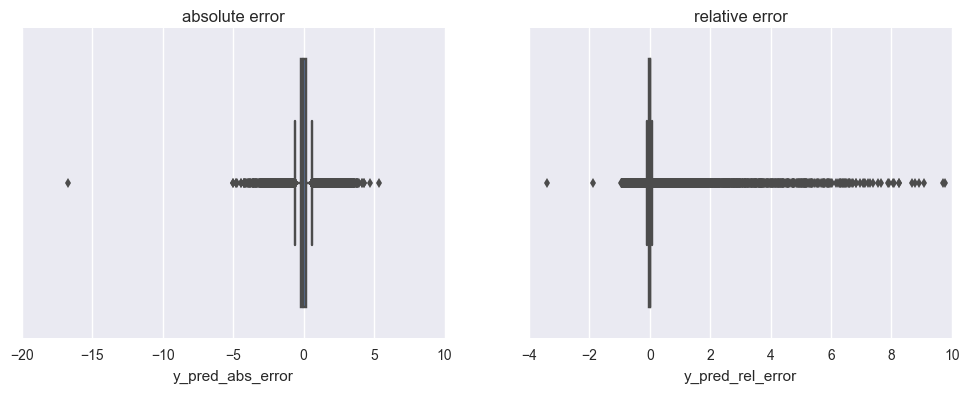

In [7]:
# Plot prediction errors boxplots
tools.plot_errors(results_merged)

<a id="erroutput"></a>
### Error with respect to measured intensity

By plotting the absolute and relative error in *output* intensity prediction against measured values, we can get an idea of whether the errors are uniformly distributed, or likely to be associated primarily with weak measured intensities.

We might expect an overabundance of large relative error for low measured intensity values, as the relative effect of a constant absolute error will be greater for these smaller values.

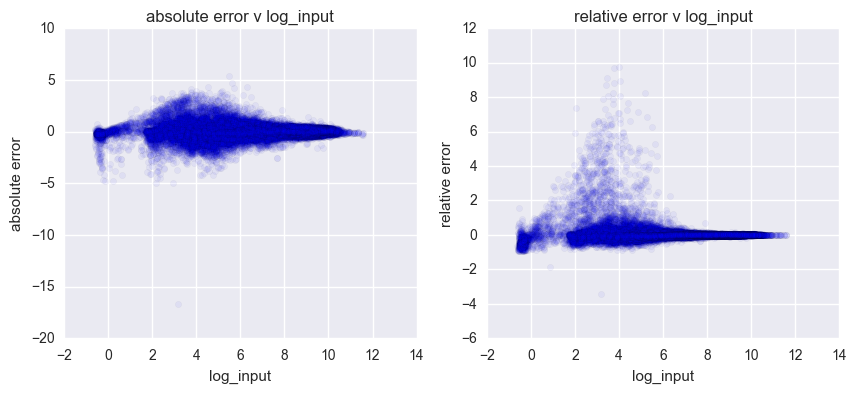

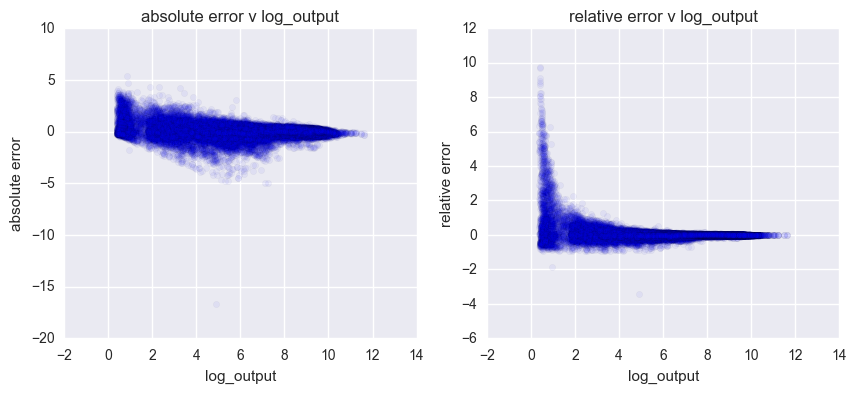

In [8]:
# Plot relative and absolute error wrt input and output
tools.plot_error_vs_column(results_merged, "log_input")
tools.plot_error_vs_column(results_merged, "log_output")

<div class="alert-success">
<b>The plots above indicate that absolute prediction errors are small for probes with intensities of 6 or greater. In particular, probes with strong intensities have very low absolute and relative error.</b>
</div>

<a id="errtrt"></a>
### Error with respect to estimated treatment effect

By relating the absolute and relative error to the estimated treatment effect, we can interpret whether we should continue to be confident in the results of notebook `02-full_model_fit.ipynb`. If the 25% percentile for our estimate of $\delta$ is greater than zero, then the 50% CI for that probe's gene does not include zero, and we interpret this as a positive effect due to treatment.

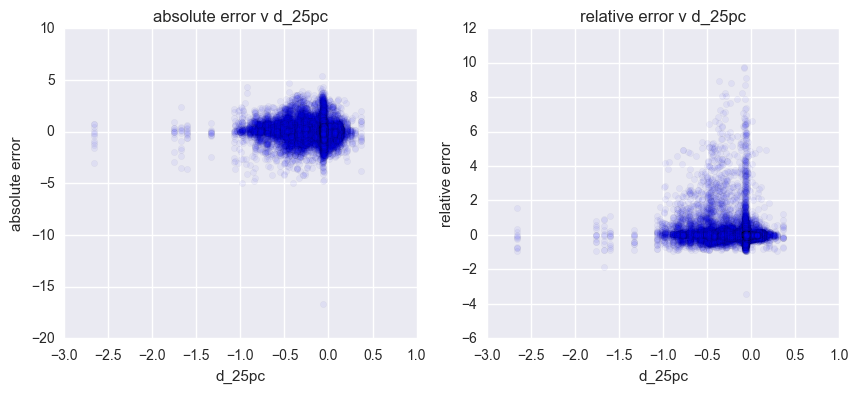

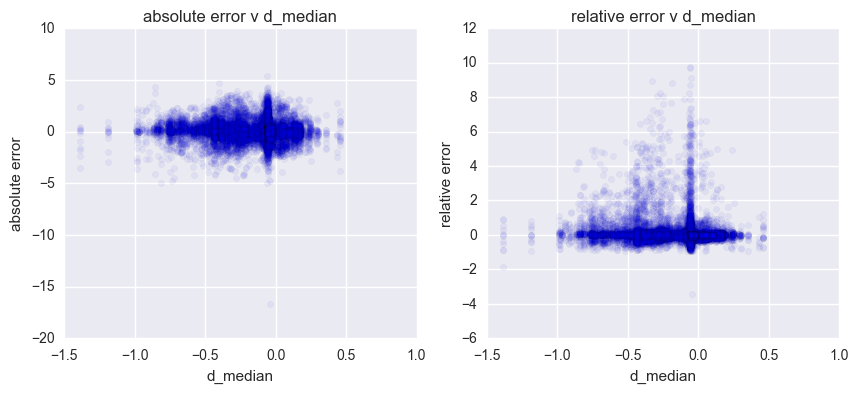

In [9]:
# Plot errors relative to 25% percentile for estimate of treatment effect
tools.plot_error_vs_column(results_merged, "d_25pc")
tools.plot_error_vs_column(results_merged, "d_median")

<br /><div class="alert-warning">
Median and 25% percentile values of $\delta_{j[i]}$ close to or less than zero are associated most frequently with large errors. A small number of large absolute and relative errors are associated with values that are positive and quite far from zero.
</div>

We subset the data to investigate this more closely, in the dataset `trt_pos` representing the 115 locus tags with an estimated positive treatment effect.

In [10]:
# Subset data to positive estimates of delta only
trt_pos = results_merged[results_merged['d_25pc'] > 0]

# Inspect results
trt_pos.head()

,locus_tag,probe,replicate,treatment,log_input,log_output,y_pred_5pc,y_pred_median,y_pred_95pc,d_2.5pc,d_25pc,d_median,d_75pc,d_97.5pc,y_pred_abs_error,y_pred_rel_error,y_diff_pred,y_diff_obs
16044,ECs0415,A_07_P053966,2,0,5.537948,4.855196,4.808470,5.571389,6.309174,-0.056614,0.138136,0.235389,0.325986,0.470599,0.716193,0.147511,0.033442,-0.682751
16045,ECs0415,A_07_P043771,1,0,4.889754,4.853641,4.034892,4.819052,5.566774,-0.056614,0.138136,0.235389,0.325986,0.470599,-0.034589,-0.007126,-0.070702,-0.036113
16046,ECs0415,A_07_P053966,3,0,2.388387,1.941498,1.680969,2.446959,3.192620,-0.056614,0.138136,0.235389,0.325986,0.470599,0.505461,0.260346,0.058572,-0.446889
16047,ECs0415,A_07_P043771,3,1,-0.523139,0.405531,-0.677318,0.062175,0.899821,-0.056614,0.138136,0.235389,0.325986,0.470599,-0.343355,-0.846681,0.585314,0.928670
16048,ECs0415,A_07_P053966,1,0,4.935381,4.910987,4.195545,4.924633,5.710152,-0.056614,0.138136,0.235389,0.325986,0.470599,0.013646,0.002779,-0.010748,-0.024394


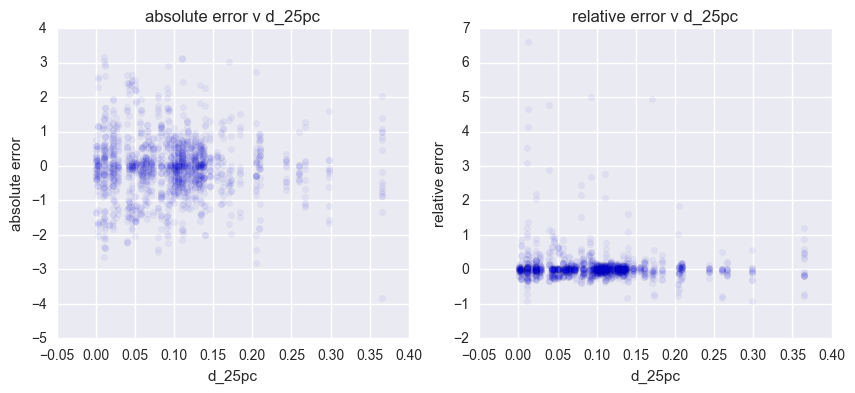

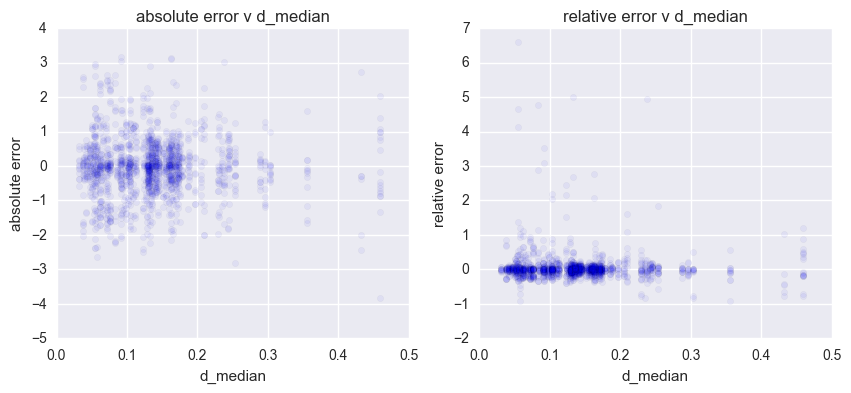

In [11]:
# Plot errors relative to 25% percentile for estimate of treatment effect
tools.plot_error_vs_column(trt_pos, "d_25pc")
tools.plot_error_vs_column(trt_pos, "d_median")

By visual inspection, most probe prediction errors for the "treatment positive" probes are small in relative terms, but appear to be Normally distributed in absolute terms with respect to the value of `d_median`. We can examine the error distributions for these probes with respect to log *input* and *output* intensities, as above.

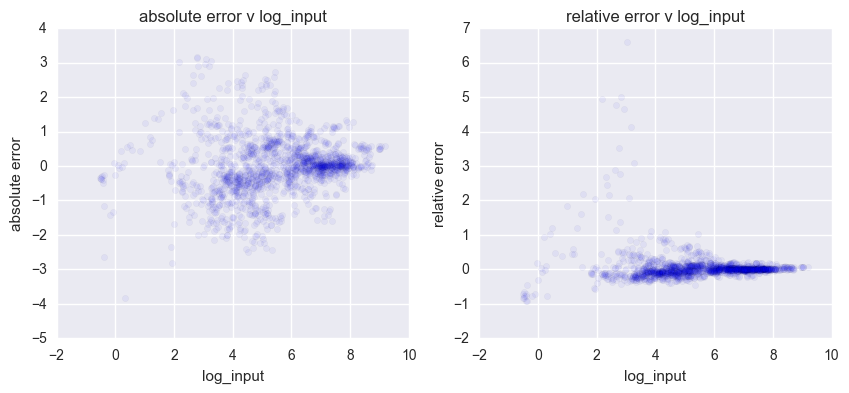

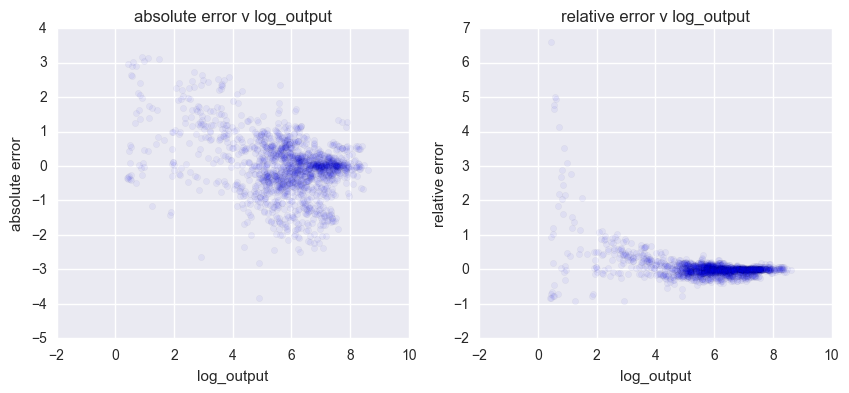

In [12]:
# Plot errors for positive treatment effects wrt measured intensities
tools.plot_error_vs_column(trt_pos, "log_input")
tools.plot_error_vs_column(trt_pos, "log_output")

<br /><div class="alert-success">
These plots show that a large relative prediction error is associated mainly with probes that have low measured *input* or *output* intensity, less than ≈4 units.
</div>

<a id="errinterval"></a>
### Error with respect to prediction interval

As an estimate of prediction accuracy, we can calculate the number of observed output intensities that lie outwith the 90% credibility interval of the prediction. We create the column `pred_success`, which contains `True` where the predicted *output* value lies in the 90% CI for the crossvalidation predictions.

In [13]:
# Add a column for probe predictions that lie outwith the 90% credibility interval of prediction
results_merged['pred_success'] = (results_merged['log_output'] > results_merged['y_pred_5pc']) & \
                                 (results_merged['log_output'] < results_merged['y_pred_95pc'])
    
# Inspect data
results_merged.head()

,locus_tag,probe,replicate,treatment,log_input,log_output,y_pred_5pc,y_pred_median,y_pred_95pc,d_2.5pc,d_25pc,d_median,d_75pc,d_97.5pc,y_pred_abs_error,y_pred_rel_error,y_diff_pred,y_diff_obs,pred_success
0,ECDH10B_RS00010,A_07_P010704,3,1,7.540075,7.233352,6.514030,7.345629,8.155571,-0.106789,-0.065958,-0.057542,-0.048565,-0.023847,0.112278,0.015522,-0.194446,-0.306724,True
1,ECDH10B_RS00010,A_07_P010704,3,0,8.703879,8.527294,7.655175,8.446265,9.183563,-0.106789,-0.065958,-0.057542,-0.048565,-0.023847,-0.081029,-0.009502,-0.257614,-0.176585,True
2,ECDH10B_RS00010,A_07_P010704,2,0,8.855490,8.342144,7.849079,8.655905,9.472783,-0.106789,-0.065958,-0.057542,-0.048565,-0.023847,0.313761,0.037612,-0.199585,-0.513347,True
3,ECDH10B_RS00010,A_07_P010704,2,1,7.541968,7.132120,6.594946,7.378912,8.161562,-0.106789,-0.065958,-0.057542,-0.048565,-0.023847,0.246792,0.034603,-0.163055,-0.409848,True
4,ECDH10B_RS00010,A_07_P010704,1,1,7.472794,7.123169,6.510460,7.328620,8.090392,-0.106789,-0.065958,-0.057542,-0.048565,-0.023847,0.205451,0.028843,-0.144174,-0.349624,True


In [14]:
# Make a dataframe of missed predictions
errors = results_merged[results_merged['pred_success'] == False]
print(errors.shape, results_merged.shape, len(errors['locus_tag'].unique()))

(4048, 19) (49872, 19) 1101


<div class="alert-success">
<b>This identifies 4048/49872 probe predictions (an 8% misprediction rate!), covering 1101 locus_tags in total.</b>
</div>

We can gain an insight into the number of probes that are likely to be in error for any particular locus tag, by plotting the distribution of their counts:

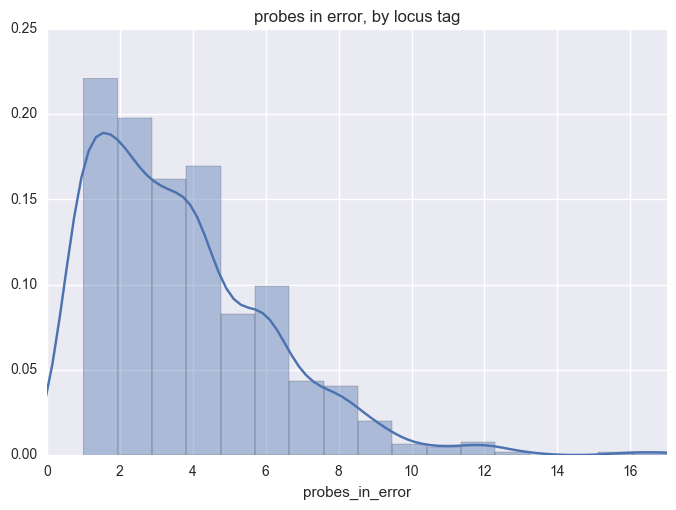

In [15]:
# Distribution of probes in error, by locus tag
error_probe_counts = errors['locus_tag'].groupby(errors['locus_tag']).agg(['count'])
error_probe_counts.columns=['probes_in_error']
ax = sns.distplot(error_probe_counts['probes_in_error'], bins=max(error_probe_counts['probes_in_error']))
ax.set_title("probes in error, by locus tag")
ax.set_xlim(0, max(error_probe_counts['probes_in_error']));

Most of the locus tags with prediction errors have errors in 4 probes or fewer (out of an average of six or so), so in general we might expect most probes for most locus tags to be relatively well-predicted by our model. 

But is this the case for the locus tags with a predicted positive treatment effect?

<a id="#errpos"></a>
### Prediction errors for positive treatment effects

We can examine the distribution of crossvalidation prediction errors for the locus tags with positive estimated treatment effect, and compare this to the distribution for the dataset as a whole. If these are similar, then there may be no systematic misprediction for the positive estimated treatment values.

In [16]:
# Subset data to positive estimates of delta only
trt_pos = results_merged[results_merged['d_25pc'] > 0]
trt_errors = trt_pos[trt_pos['pred_success'] == False]
print(trt_errors.shape, trt_pos.shape, len(trt_errors['locus_tag'].unique()))

(389, 19) (1566, 19) 77


<div class="alert-danger">
<b>We find that 389/1566 of our probes (around 25% of predictions, covering 77 of the 115 locus tags with an estimated positive effect) have measured output intensity that lies outwith the 90% CI for the crossvalidation prediction. This is a considerably higher rate than for the dataset as a whole.</b>
</div>

Plotting the distribution of the number of probes in error for each locus tag also shows a noisier distribution to that for the main dataset, where some predictions have a much larger number of probe predictions that appear to be in error:

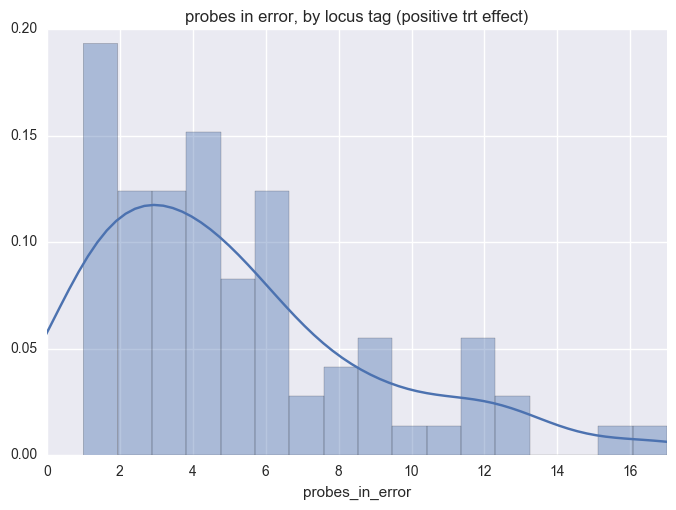

In [17]:
trt_error_probe_counts = trt_errors['locus_tag'].groupby(trt_errors['locus_tag']).agg(['count'])
trt_error_probe_counts.columns=['probes_in_error']
ax = sns.distplot(trt_error_probe_counts['probes_in_error'], bins=max(trt_error_probe_counts['probes_in_error']))
ax.set_title("probes in error, by locus tag (positive trt effect)")
ax.set_xlim(0, max(trt_error_probe_counts['probes_in_error']));

The modal number of probes in error is one, but the distribution has a different shape to that for the complete dataset, suggesting a systematic failure of the model to predict precisely the *output* intensity for some probes.

<a id="candidates"></a>
## Prediction errors for positive treatment effect candidates

We break down the prediction errors for our positive treatment effect candidates into two types (after [Gelman & Carlin (2014) DOI: 10.1177/1745691614551642](http://www.stat.columbia.edu/~gelman/research/published/PPS551642_REV2.pdf)). 

* **Type S (sign)**: the difference between predicted output intensity and measured input intensity has the opposite sign to that for the difference between measured output intensity and measured input intensity
* **Type M (magnitude)**: the *direction* of the prediction is correct (no Type S error), but the magnitude is incorrect

<br /><div class="alert-warning">
A large proportion of predictions with a Type S error may be critically indicative of a misestimate of $\delta$ for a given locus tag. By contrast, a preponderance of Type M errors might indicate a generally correct estimate that there is an effect, but for some reason (perhaps a faulty run that has a strong effect on the crossvalidation training set) misestimates the magnitude of $\delta$.
</div>

<a id="calc_errors"></a>
### Calculating Type M and Type S errors

We create two new columns in the `trt_pos` dataframe that contains estimates for those locus tags with an estimated positive value for $\delta$, the effect on treatment/passage:

* `type_s`: there is a prediction error, and the sign of the predicted and observed differences are the same value - `trt_pos['y_diff_pred']/trt_pos['y_diff_obs'] > 0`
* `type_m`: there is a prediction error, but it's not Type S - `trt_pos['type_s'] is False and trt_pos['pred_success'] is False`


In [18]:
# Create columns for error types
trt_pos['type_s'] = trt_pos['pred_success'] is False and (trt_pos['y_diff_pred']/trt_pos['y_diff_obs'] < 0)
trt_pos['type_m'] = (trt_pos['type_s'] == False) & (trt_pos['pred_success'] == False)

# Inspect data
trt_pos.head()

,locus_tag,probe,replicate,treatment,log_input,log_output,y_pred_5pc,y_pred_median,y_pred_95pc,d_2.5pc,...,d_median,d_75pc,d_97.5pc,y_pred_abs_error,y_pred_rel_error,y_diff_pred,y_diff_obs,pred_success,type_s,type_m
16044,ECs0415,A_07_P053966,2,0,5.537948,4.855196,4.808470,5.571389,6.309174,-0.056614,...,0.235389,0.325986,0.470599,0.716193,0.147511,0.033442,-0.682751,True,False,False
16045,ECs0415,A_07_P043771,1,0,4.889754,4.853641,4.034892,4.819052,5.566774,-0.056614,...,0.235389,0.325986,0.470599,-0.034589,-0.007126,-0.070702,-0.036113,True,False,False
16046,ECs0415,A_07_P053966,3,0,2.388387,1.941498,1.680969,2.446959,3.192620,-0.056614,...,0.235389,0.325986,0.470599,0.505461,0.260346,0.058572,-0.446889,True,False,False
16047,ECs0415,A_07_P043771,3,1,-0.523139,0.405531,-0.677318,0.062175,0.899821,-0.056614,...,0.235389,0.325986,0.470599,-0.343355,-0.846681,0.585314,0.928670,True,False,False
16048,ECs0415,A_07_P053966,1,0,4.935381,4.910987,4.195545,4.924633,5.710152,-0.056614,...,0.235389,0.325986,0.470599,0.013646,0.002779,-0.010748,-0.024394,True,False,False


In [19]:
# How many errors of each type?
print("Type S errors: %d" % sum(trt_pos['type_s']))
print("Type M errors: %d" % sum(trt_pos['type_m']))

Type S errors: 0
Type M errors: 389


<div class="alert-success">
<b>There are no observed Type S errors.</b>
</div>

All errors in the predicted output intensity are Type M errors: errors in the predicted effect magnitude, where the effect is observed to be in the correct direction, with respect to the input intensity.

<div class="alert-success">
<b>We should, therefore, be confident that our predictions of $\delta$ are accurate in terms of their positive direction.</b>
</div>

<a id="overunder"></a>
### Over- and Under-estimates

The question arises whether the errors are typically underestimates or overestimates, for the probes that are in error. If we are systematically overestimating output probe intensity, then we might consider our estimates of $\delta$ to be generally too large. Alternatively, if we are systematically *underestimating* output probe intensity, we might thing that our estimates are too small.

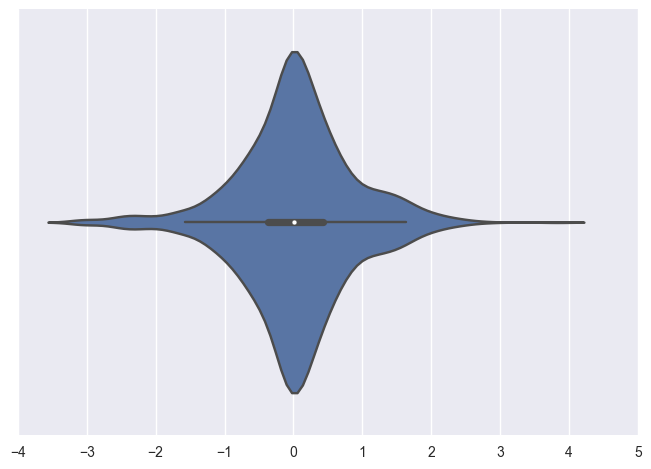

In [20]:
# Violinplot of prediction error for all probes
sns.violinplot(trt_pos['log_output'] - trt_pos['y_pred_median']);

In general, most probe predictions are within one log unit of the observed value for the probes corresponding to positive treatment effects. This is encouraging and suggests that, in general, the parameter estimates and model are appropriate.

180 positive errors
209 negative errors


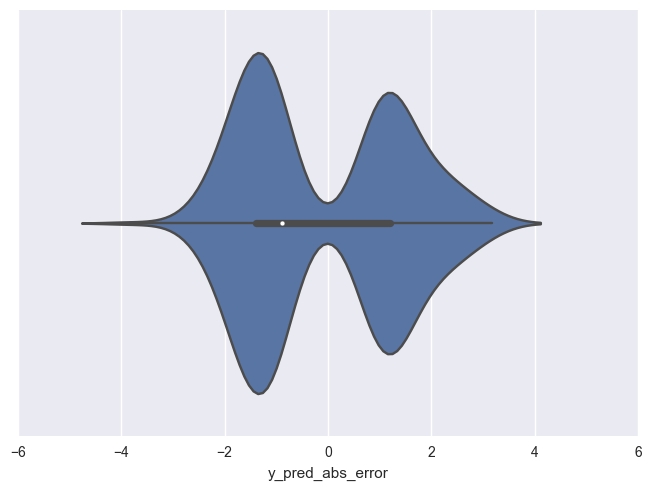

In [21]:
# Violinplot of prediction error for probes where prediction fails
trt_errors = trt_pos[trt_pos['pred_success'] == False]
print("%d positive errors" % sum(trt_errors['y_pred_abs_error'] > 0))
print("%d negative errors" % sum(trt_errors['y_pred_abs_error'] < 0))
sns.violinplot(trt_errors['y_pred_abs_error']);

<div class="alert-success">
<b>The violinplot of errors for probes whose observed output isn't in the 90% CI for the predicted output indicates that most errors are less than 2 log units from the observed value in either direction. The number of positive and negative errors are also very similar, suggesting that there is no systematic bias towards over- or under-estimation.</b>
</div>

<a id="questionable"></a>
### Questionable locus tags

Although our results seem to be on the whole quite sound, there are some locus tags for which the results may be more questionable. We can identify the total number of probes for each locus tag, and the number of probe output predictions that are in error, and determine which locus tags appear to have an unusually high proportion of errors as having more questionable estimates.

We generate a dataframe, indexed by locus tag, with a column `fail_prop` that describes the proportion of probe predictions that are in error.

In [22]:
# Count number of probes and failed predictions, by locus tag
collist = ['d_2.5pc', 'd_25pc', 'd_median', 'd_75pc', 'd_97.5pc',
           'pred_success', 'type_m']
lt_pos = trt_pos.groupby('locus_tag').agg(sum)[collist]
lt_pos['fail_prop'] = lt_pos['type_m']/(lt_pos['type_m'] + lt_pos['pred_success'])
lt_pos.reset_index(inplace=True)

# Inspect output
lt_pos.head()

,locus_tag,d_2.5pc,d_25pc,d_median,d_75pc,d_97.5pc,pred_success,type_m,fail_prop
0,ECs0415,-0.679367,1.657636,2.824671,3.911833,5.647189,11.0,1.0,0.083333
1,ECs0416,-0.708834,1.076814,2.096457,2.877068,4.219646,7.0,5.0,0.416667
2,ECs1121,-1.702318,0.325971,1.718081,2.744757,4.574203,21.0,9.0,0.300000
3,ECs1161,0.574855,2.044636,2.851780,3.569380,4.874645,8.0,4.0,0.333333
4,ECs1262,0.909954,1.923403,2.364237,2.861817,3.649701,7.0,5.0,0.416667


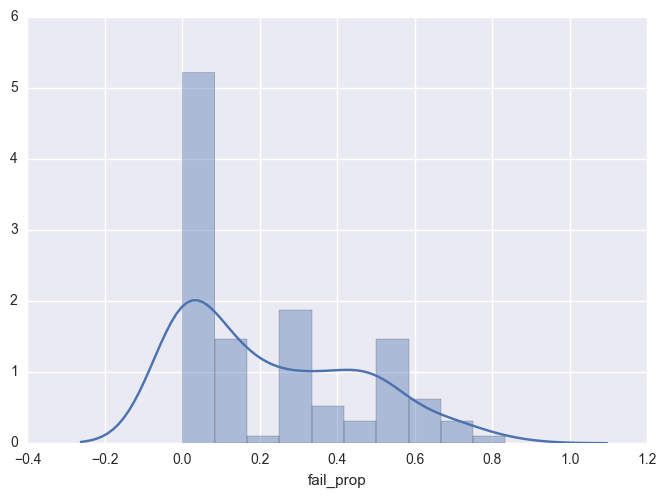

In [23]:
# Distribution of proportion of failed probes
sns.distplot(lt_pos['fail_prop'], bins=10);

From this data, we see that most locus tags in this dataset have no probe errors, and a small proportion have more than 50% probe errors. We can inspect the predictions for those locus tags directly.

In [24]:
# Make list of locus tags with more than 50% probe errors
q_tags = lt_pos.loc[lt_pos['fail_prop'] > 0.5]
print(q_tags.shape, sum(q_tags['type_m']))

(10, 9) 110.0


<div class="alert-success">
<b>This identifies 10 questionable locus tags, with 110 Type M probe errors, in total.</b>
</div>

We use the function `plot_locustag_predictions()` to visualise the prediction results for these genes directly. In these plots, values 0-2 indicate control replicates, and values 3-5 treatment replicates. The grey points show measured input intensity for the probe, and the black points show measured output intensity. The coloured points show predicted median values, and the bars indicate the 90% credibility interval for the prediction.

Yellow and blue bars indicate that the observed output intensity lies within the 90% CI; green and red bars indicate that the observed output value lies outwith the 90% CI.

85     ECs4325
86     ECs4329
88     ECs4335
89     ECs4339
90     ECs4341
91     ECs4353
92     ECs4354
94     ECs4380
100    ECs4386
101    ECs4387
Name: locus_tag, dtype: object


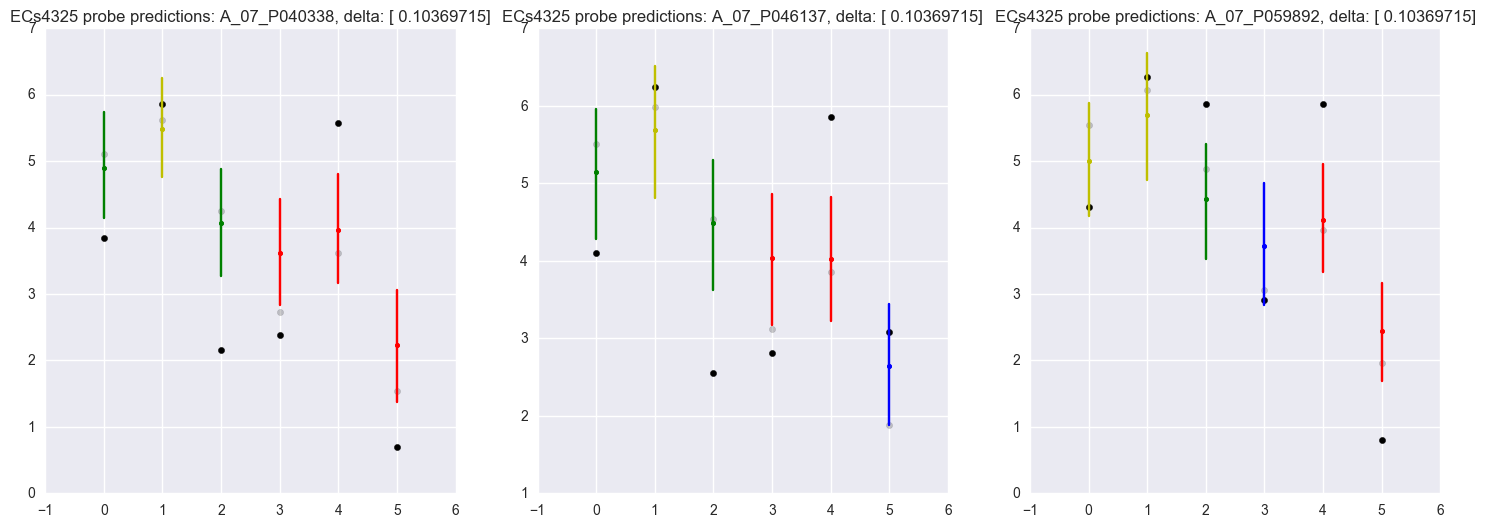

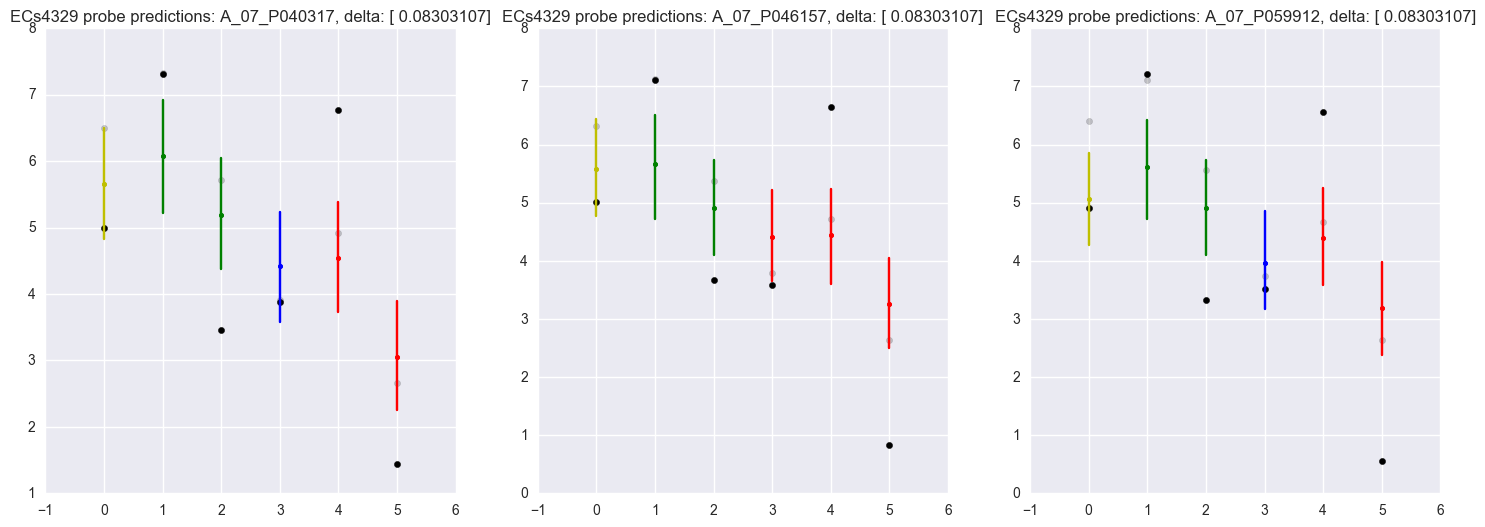

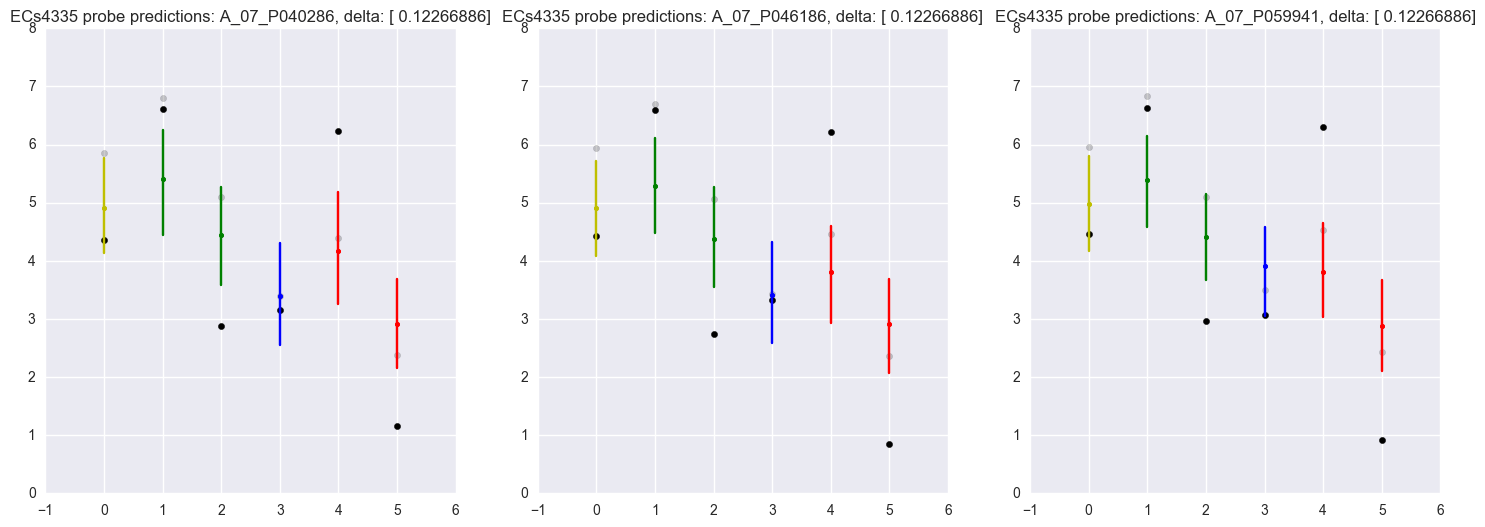

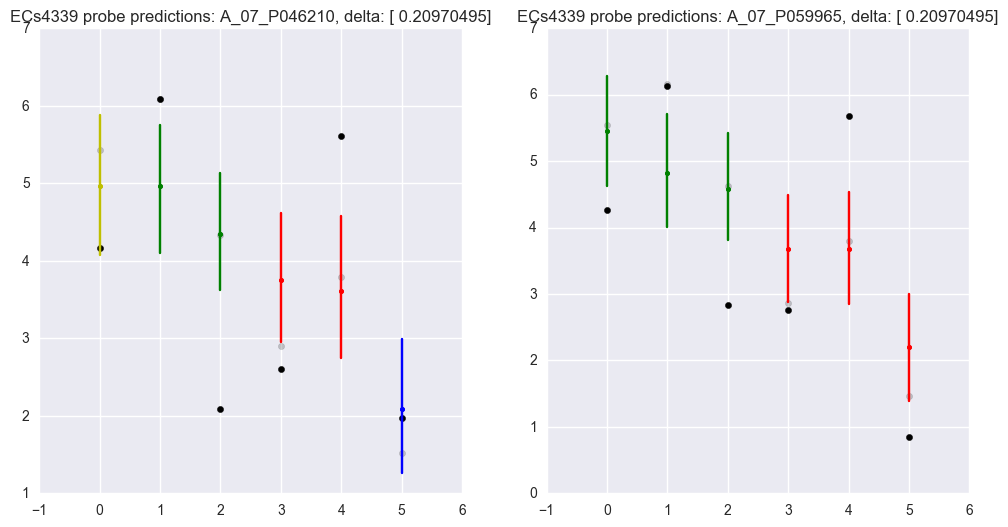

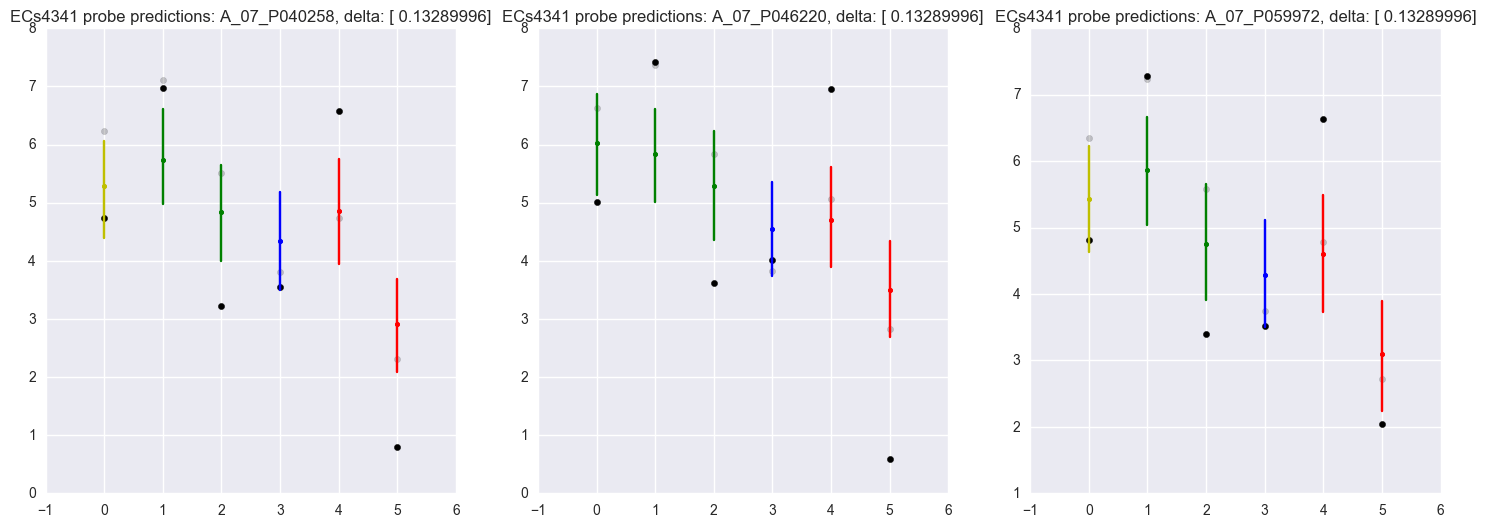

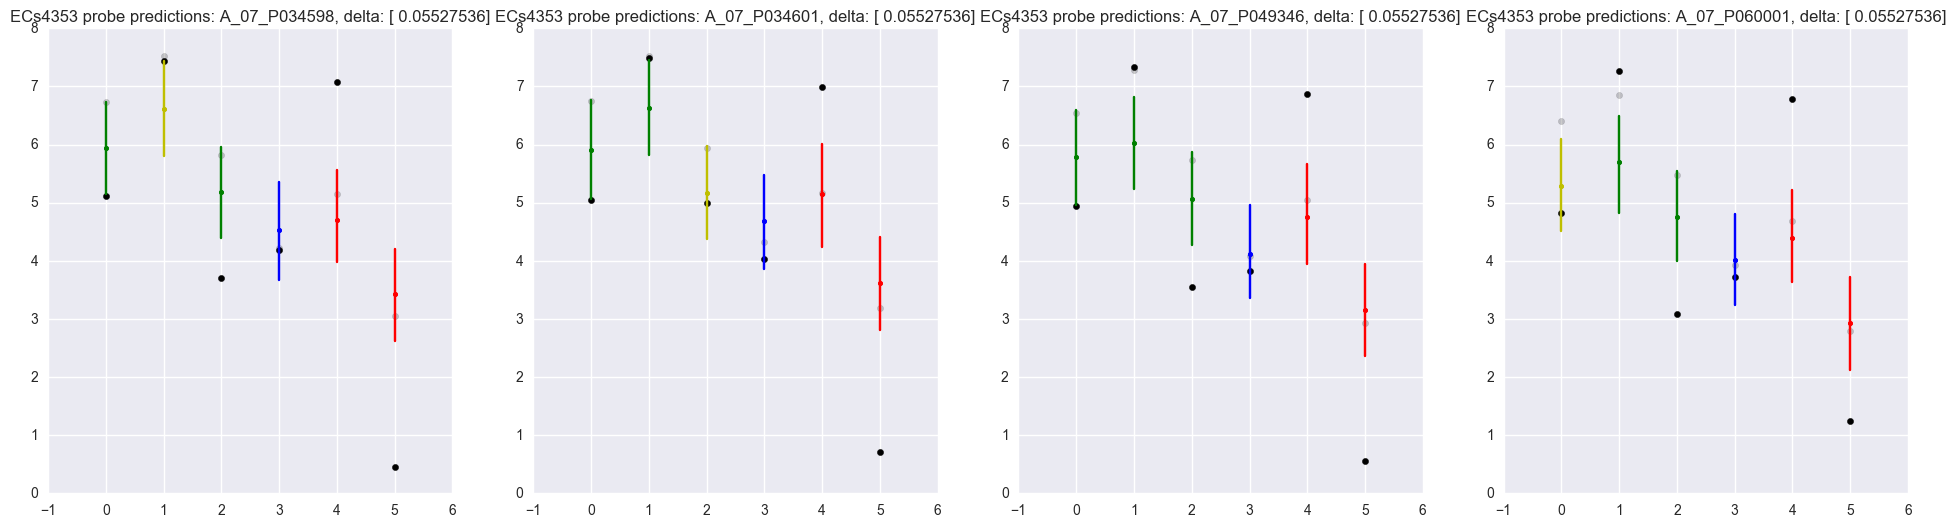

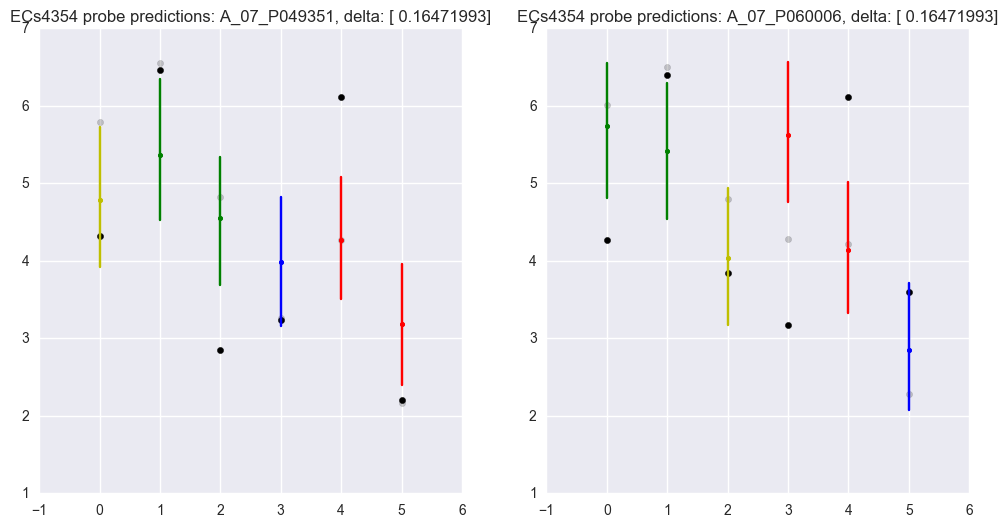

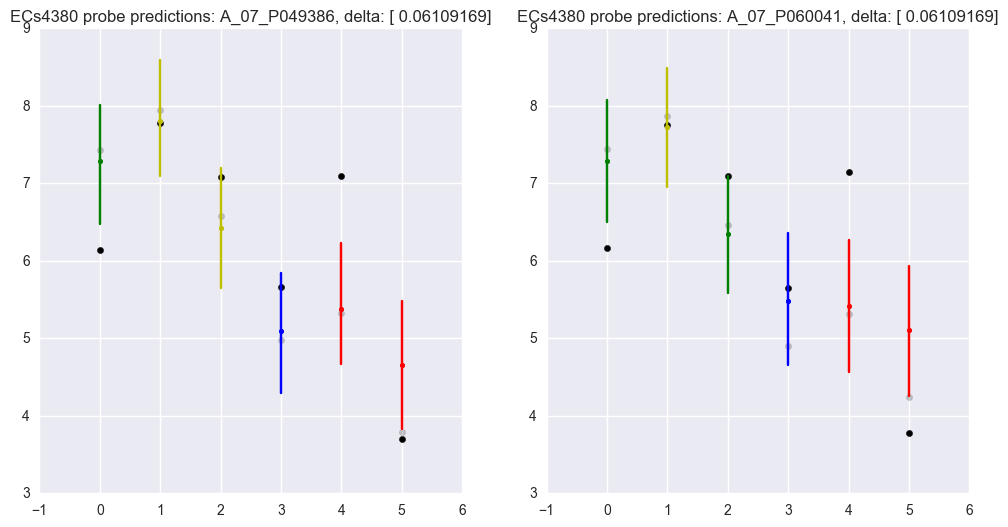

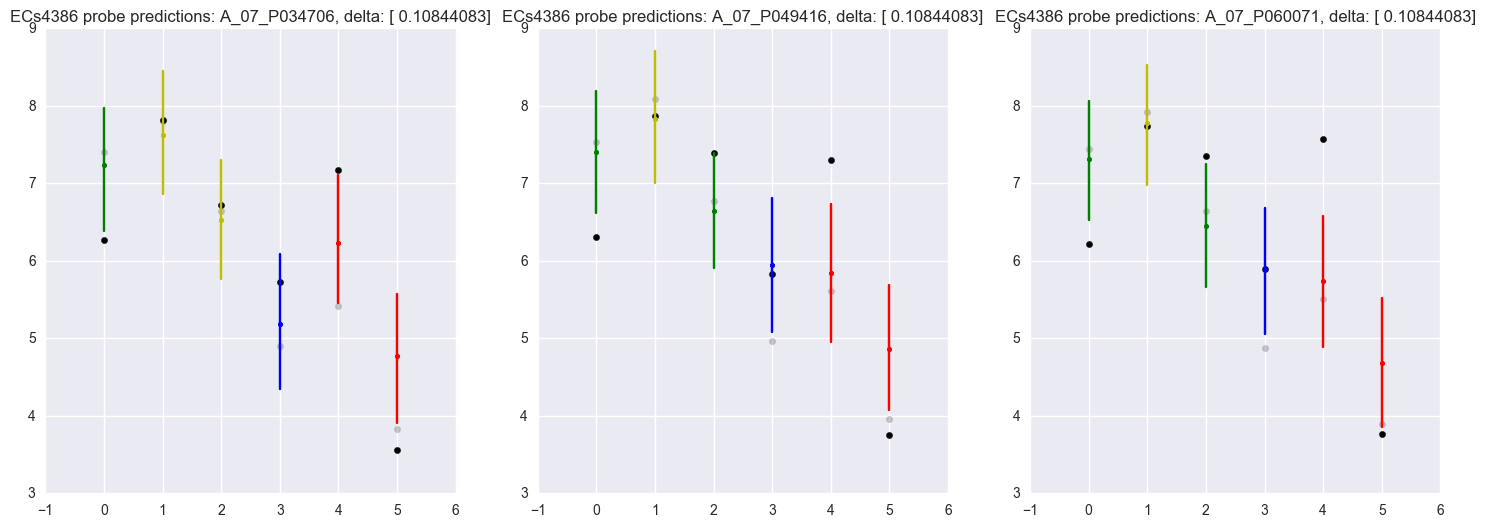

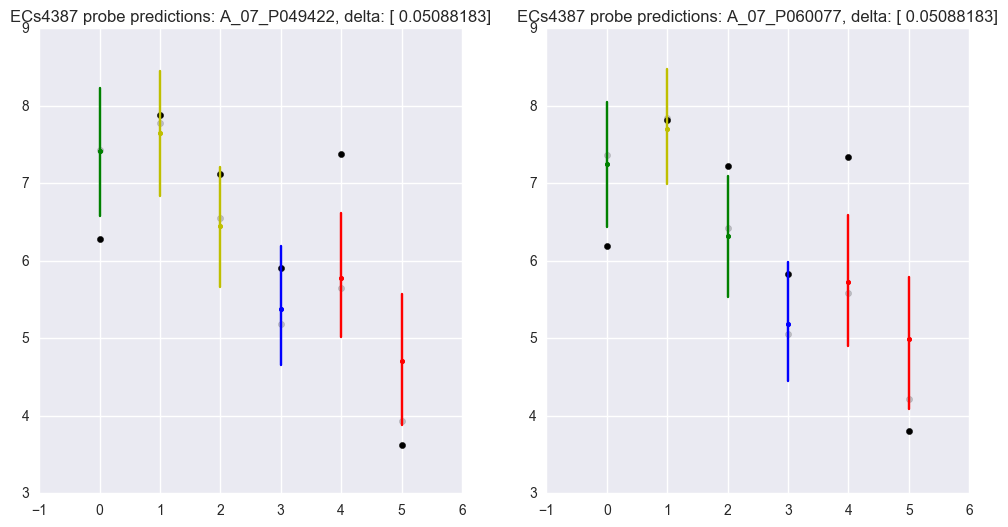

In [25]:
# Plot predictions for each questionable locus tag
print(q_tags['locus_tag'])
for lt in q_tags['locus_tag']:
    tools.plot_locustag_predictions(trt_pos, lt)

These ten locus tags explain nearly 1/3 of all Type M errors in the positive treatment dataset, and are closely collocated on the genome, from `ECs4325` to `ECs4387`, and so may be subject to the same effects of BAC over- or under-representation. Where this occurs, a single pool may give an erroneous result due to the aberrational effets of over- or under-representation, and this may skew our crossvalidation predictions.

Visual inspection of the plots above indicates that the crossvalidation parameter estimates for $\delta$ were typically positive, and those for $\beta$ negative. They also indicate that the observed output intensities for the treatment and control values were not consistent.

For instance, for `ECs4387` control samples 1 and 2 showed an increase in intensity post-experiment, but sample 0 shows quite a sharp decrease in intensity. Similarly, treatment samples 3 and 4 show an increase in post-experiment intensity, but sample 5 shows a decrease.

Similar inconsistencies are observed for all ten locus tags in this region, and BAC over or under-representation in the pools may be a possible physical cause of this.